In [19]:
import os
import numpy as np 
import scipy.stats as sp
from uhod import camels as CAMELS

import astropy.table as atable

In [2]:
import corner as DFM
import matplotlib.pyplot as plt

# read in LHC parameter values

In [4]:
params = CAMELS.LHC(sim='tng')

# read in AHF catalogs

In [6]:
ahf = [] 
for i in range(1000): 
    _ahf = CAMELS.AHF(33, real='LH_%i' % i)
    _ahf['Om'] = np.repeat(params[i,0], len(_ahf))
    _ahf['s8'] = np.repeat(params[i,1], len(_ahf))
    _ahf['A1'] = np.repeat(params[i,2], len(_ahf))
    _ahf['A2'] = np.repeat(params[i,3], len(_ahf))
    _ahf['A3'] = np.repeat(params[i,4], len(_ahf))
    _ahf['A4'] = np.repeat(params[i,5], len(_ahf))    
    ahf.append(_ahf)
ahf = atable.vstack(ahf)

In [7]:
ahf['logMvir'] = np.log10(ahf['Mvir'])
ahf['logMstar'] = np.log10(ahf['M_star'])

/home/chhahn/.conda/envs/uhod/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [22]:
ahf.write(os.path.join('/home/chhahn/projects/uhod/src/uhod/dat/', 'combined_ahf.hdf5'), format='hdf5')

/home/chhahn/.conda/envs/uhod/lib/python3.7/site-packages/astropy/io/misc/hdf5.py:283: UserWarning: table path was not set via the path= argument; using default path __astropy_table__
  "using default path {}".format(path))


In [8]:
is_halo = (ahf['hostHalo'] == 0) # halo not a subhalo 
halos = ahf[is_halo]

In [9]:
has_galaxy = (halos['M_star'] > 0)

# halos with central galaxies
ncen_h = np.zeros(len(halos))
ncen_h[has_galaxy] = 1.

has_massive_galaxy = (halos['M_star'] > 1e9)
ncen_logmcut_h = np.zeros(len(halos))
ncen_logmcut_h[has_massive_galaxy] = 1.

nsat_h = halos['numSubStruct']

(0.0, 3.0)

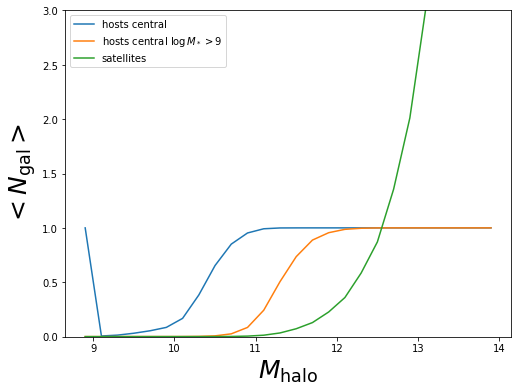

In [10]:
ncen_mh, mh_edges, _ = sp.binned_statistic(halos['logMvir'], ncen_h, bins=30, range=(8., 14))
ncen_mh_logmcut, _, _ = sp.binned_statistic(halos['logMvir'], ncen_logmcut_h, bins=30, range=(8., 14))
nsat_mh, mh_edges, _ = sp.binned_statistic(halos['logMvir'], nsat_h, bins=30, range=(8., 14))

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.plot(0.5*(mh_edges[:-1] + mh_edges[1:]), ncen_mh, label='hosts central')
sub.plot(0.5*(mh_edges[:-1] + mh_edges[1:]), ncen_mh_logmcut, label=r'hosts central $\log M_* > 9$')
sub.plot(0.5*(mh_edges[:-1] + mh_edges[1:]), nsat_mh, label='satellites')

sub.legend(loc='upper left', fontsize=10)
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=25)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=25)
sub.set_ylim(0., 3)

In [11]:
halo_props = np.vstack([halos[prop].data for prop in ['logMvir', 'Vmax', 'sigV', 'lambda', 'cNFW', 'Om', 's8', 'A1', 'A2', 'A3', 'A4']]).T

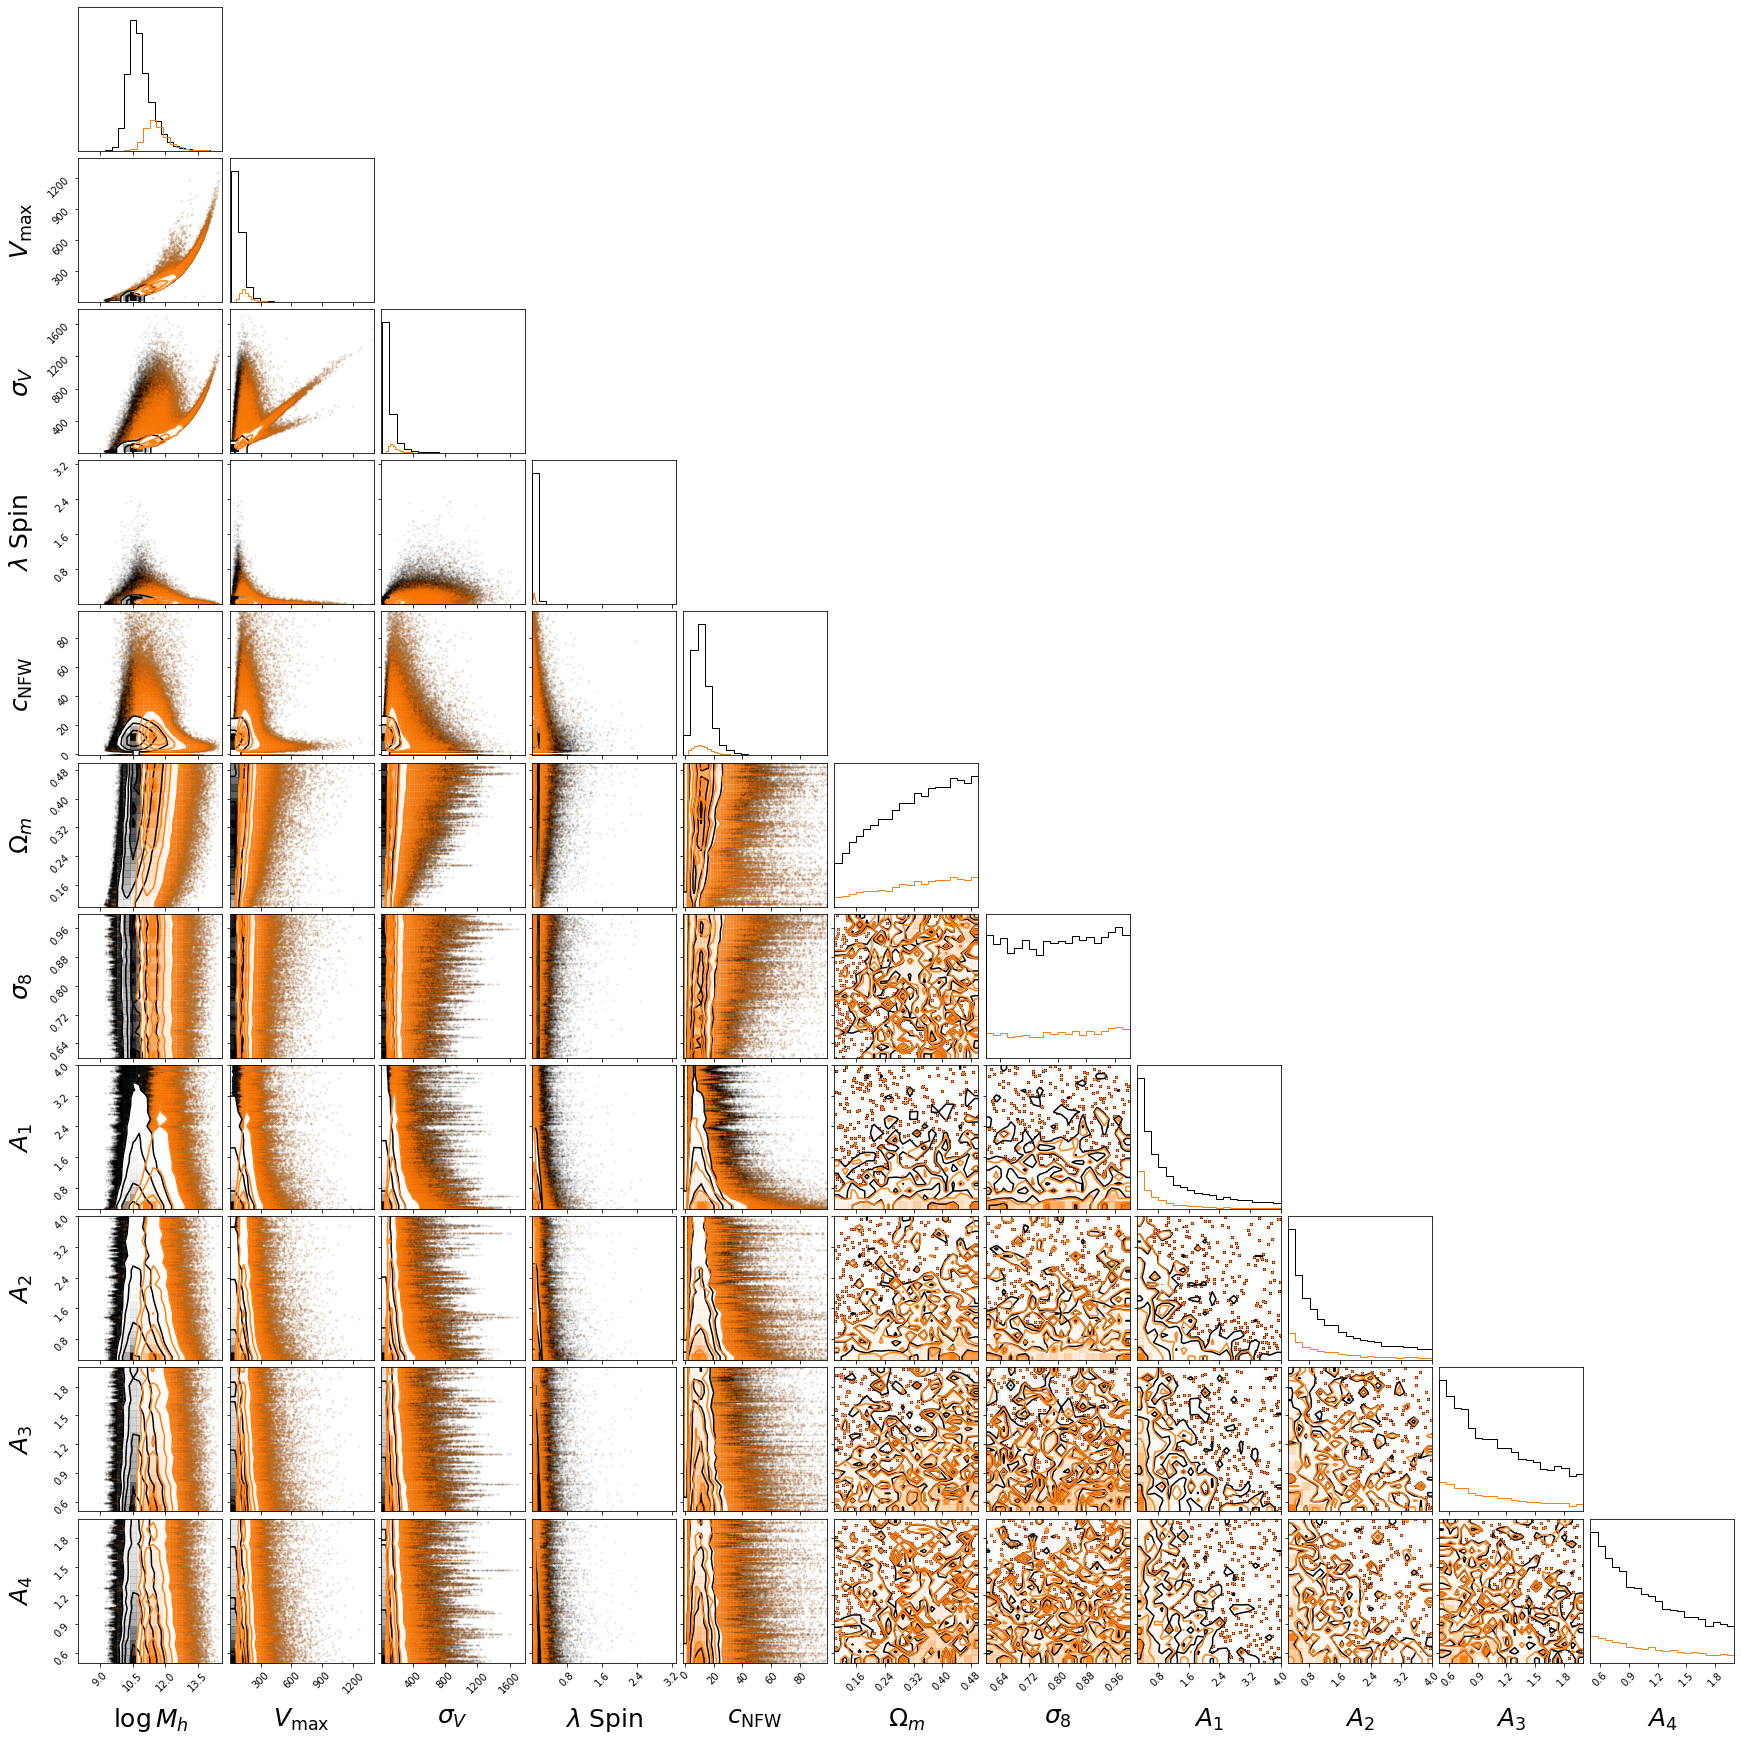

In [15]:
fig = DFM.corner(halo_props[ncen_h.astype(bool)])
_ = DFM.corner(halo_props[ncen_logmcut_h.astype(bool)], color='C1', fig=fig,
                range=[(8., 14.), (0., 600), (0, 600), (0., 0.5), (0., 45), (0.1, 0.5), (0.6, 1.), (0.25, 4.), (0.25, 4.), (0.5, 2.), (0.5, 2.)], 
                labels=[r'$\log M_h$', r'$V_{\rm max}$', r'$\sigma_V$', r'$\lambda$ Spin', r'$c_{\rm NFW}$', r'$\Omega_m$', r'$\sigma_8$', r'$A_1$', r'$A_2$', r'$A_3$', r'$A_4$'], 
                label_kwargs={'fontsize': 25})